# 学習、検証、推論
- モデルは、実装が楽＆検証が楽＆計算時間が短いのでLightGBMにする

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ptitprince import RainCloud
from pandarallel import pandarallel
from datetime import datetime as dt
import math
import sys
sys.path.append('../module/')
import models
import features
import utils
import importlib
from sklearn.model_selection import StratifiedKFold

importlib.reload(models)
importlib.reload(features)
importlib.reload(utils)
pandarallel.initialize()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Define func

In [6]:
def str2time(df):
    out_df = df.copy()
    out_df['Date'] = df['Date'].parallel_apply(lambda x:dt.strptime(x,'%Y-%m-%d'))
    out_df['Month'] = out_df['Date'].dt.month
    out_df['Year'] = out_df['Date'].dt.year
    out_df['Week'] = out_df['Date'].dt.week
    return out_df

def identity_func(df):
    return df[use_col].copy()

# Config

In [7]:
INPUT = '../input/'
OUTPUT = '../output/'
SEED = 12
N_SPLIT = 5

In [8]:
train = pd.read_csv(INPUT+'train.csv')
test = pd.read_csv(INPUT+'test.csv')
feature = pd.read_csv(INPUT+'features.csv')
stores = pd.read_csv(INPUT+'stores.csv')
sample = pd.read_csv(INPUT+'sampleSubmission.csv')

train_df = pd.merge(train,feature.drop(columns='IsHoliday'),how='left',on=['Store','Date'])
train_df = pd.merge(train_df,stores,how='left',on='Store')
test_df = pd.merge(test,feature.drop(columns='IsHoliday'),how='left',on=['Store','Date'])
test_df = pd.merge(test_df,stores,how='left',on='Store')

target = train_df['Weekly_Sales']
loss_weight = train_df['IsHoliday'].parallel_apply(lambda x:5 if x else 1)

#軽く前処理
train_df = str2time(train_df)
test_df = str2time(test_df)

ipykernel_launcher:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


# Pre Process

In [9]:
# そのまま使うカラム指定
use_col = ['Store','Dept','IsHoliday','Size','Month','Week']

In [10]:
#特徴量作成
process_block = [
    features.WrapperBlock(identity_func),#そのまま使う特徴量
    features.BeforesalesBlock(),#そのStoreのそのDeptの一年前のWeekly_Sales
    *[features.GroupBlock(tgt,key,func) for key in ['Store','Dept','Week','Month','IsHoliday','Type'] for tgt in ['Weekly_Sales'] for func in ['min','max','mean','median']],#Weekly_Sales使ってるからleakしてるかもデータ数多いからとりあえずこれでやってみる。
    *[features.GroupshiftBlock(key,i) for key in ['Month','Week']  for i in [1,2,3,4,-1,-2,-3,-4]],#keyでgroupbyしてiだけshift
    *[features.GroupdiffBlock(key,i) for key in ['Month','Week']  for i in [1,2,3,4,-1,-2,-3,-4]],#keyでgroupbyしてiだけdiff(差分)
    *[features.GrouppctBlock(key,i) for key in ['Month','Week']  for i in [1,2,3,4,-1,-2,-3,-4]],#keyでgroupbyしてiだけpct_change(変化率)
    *[features.GrouprollingBlock(key,i) for key in ['Month','Week']  for i in [3,4,5]],#keyでgroupbyしてiでrollingして平均(移動平均)
    features.LabelEncodingBlock(['Type']),
]

train_feat_df = features.to_feature(train_df,process_block,is_train=True)#
test_feat_df = features.to_feature(test_df,process_block,is_train=False)

  2%|▏         | 2/81 [00:00<00:04, 18.53it/s]create<features.WrapperBlock object at 0x7f64cf8045d0> 0.021[s]
create<features.BeforesalesBlock object at 0x7f64cf804490> 0.076[s]
create<features.GroupBlock object at 0x7f64cf7fa090> 0.022[s]
create<features.GroupBlock object at 0x7f64cf7faf50> 0.020[s]
create<features.GroupBlock object at 0x7f64cf7fad10> 0.020[s]
create<features.GroupBlock object at 0x7f64cf7fa3d0> 0.022[s]
 12%|█▏        | 10/81 [00:00<00:02, 29.48it/s]create<features.GroupBlock object at 0x7f64cf7fa050> 0.020[s]
create<features.GroupBlock object at 0x7f64cf7fae10> 0.020[s]
create<features.GroupBlock object at 0x7f64cf7faed0> 0.020[s]
create<features.GroupBlock object at 0x7f64cf7fa850> 0.023[s]
create<features.GroupBlock object at 0x7f64cf7fa690> 0.021[s]
create<features.GroupBlock object at 0x7f64cf7fa590> 0.020[s]
 20%|█▉        | 16/81 [00:00<00:02, 25.33it/s]create<features.GroupBlock object at 0x7f64cf7fa750> 0.020[s]
create<features.GroupBlock object at 0x7f64cf7

## Fit & Predict

In [11]:
#Weekの個数を揃えたほうが良さそうなのでStratifiedKfold
fold = StratifiedKFold(n_splits=N_SPLIT,random_state=SEED)
cv = list(fold.split(train_feat_df,train_feat_df['Week']))

/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [12]:
#tuning済みparam
lgbm_parms = {'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'l1',
 'random_state': 13,
 'feature_pre_filter': False,
 'lambda_l1': 4.4771837825712455e-05,
 'lambda_l2': 0.005211795693107114,
 'num_leaves': 255,
 'feature_fraction': 0.8480000000000001,
 'bagging_fraction': 0.6128885143757212,
 'bagging_freq': 1,
 'min_child_samples': 50,
 'random_state':SEED}

model = models.Lgbm(lgbm_parms)
oof_preds,test_preds,evals_results = model.cv(target,loss_weight,train_feat_df,test_feat_df,cv)

/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Dept', 'IsHoliday', 'Month', 'Store', 'Type', 'Week']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2930
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 86
/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict 

# Visualize result

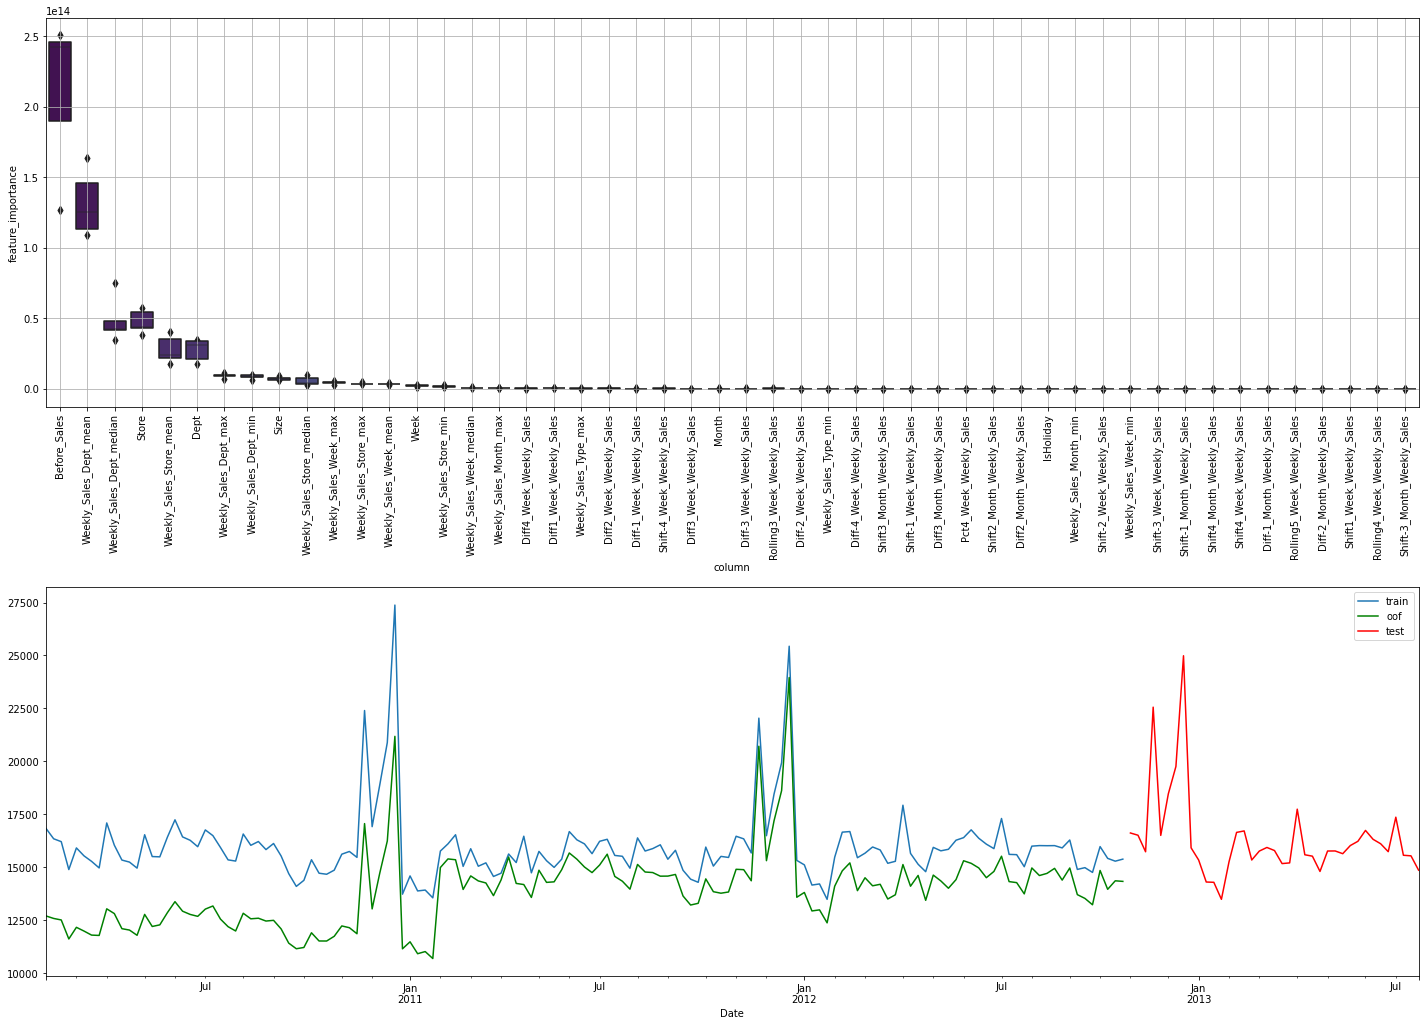

In [13]:
fig,ax = model.visualize_importance()
result = test_df.copy()
result['Weekly_Sales'] = test_preds
result_train = train_df.copy()
result_train['Weekly_Sales'] = oof_preds


train_df.groupby('Date')['Weekly_Sales'].mean().plot()
result_train.groupby('Date')['Weekly_Sales'].mean().plot(color='g')
result.groupby('Date')['Weekly_Sales'].mean().plot(color='r')
plt.legend(['train','oof','test'])

# Adversal validation
- trainとtestの分布はかなり似ていた。
- 下の結果は、Before_Sales入れた後の結果

In [416]:
#adversal validation
adversal_params = {'boosting_type': 'gbdt',
 'objective': 'cross_entropy'}
 
adversal_model = models.Lgbm(adversal_params)
adversal_model.adversal_validation(train_feat_df,test_feat_df)

/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Dept', 'IsHoliday', 'Month', 'Store', 'Type', 'Week']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 429307.000000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 429307, number of used features: 86
/home/yuuki/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Ove

(array([0.99992976, 0.99971552, 0.9999356 , ..., 0.55849058, 0.55785962,
        0.54514178]),
 {'evals_result': {'oof_score': 0.8807577006958948,
   'n_data': 421570,
   'n_features': 87}})

(<Figure size 1440x1008 with 2 Axes>,
 array([<AxesSubplot:xlabel='column', ylabel='feature_importance'>,
        <AxesSubplot:>], dtype=object))

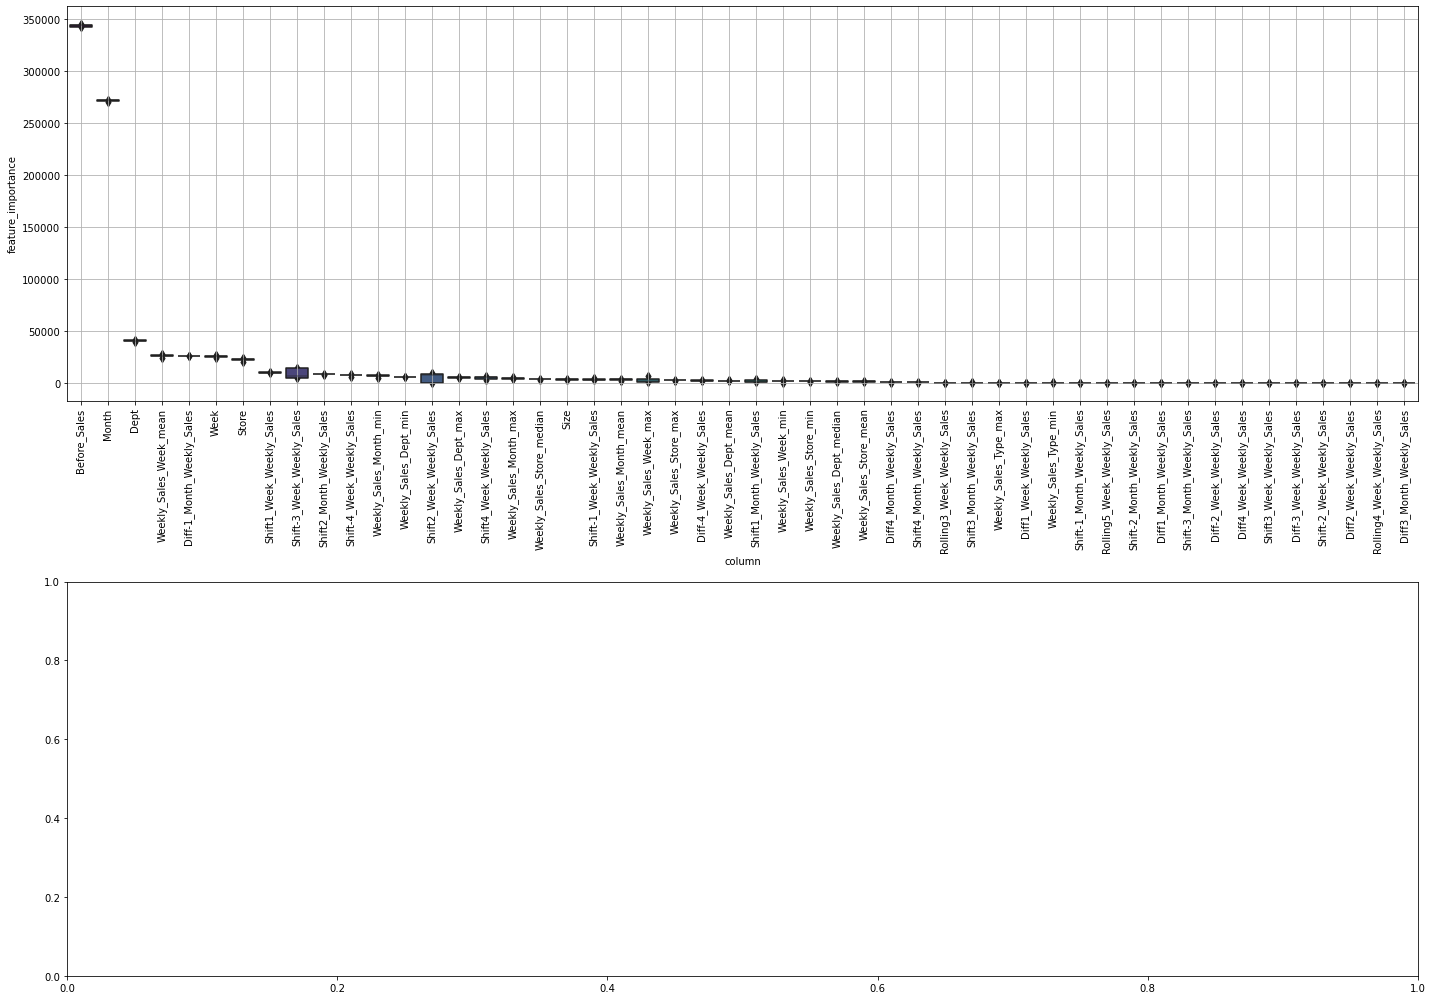

In [417]:
adversal_model.visualize_importance()

# Tuning
- optunaでtuning初手はこれが一番早い
- private:3544　→ private:2921まで改善

In [404]:
tune_params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "metric": "mae",
        "verbose":100,
        'random_state':SEED}

tuner_cv,best_params = model.tuning(target,train_feat_df,tune_params,cv)
print(best_params)

Re-bagging, using 206976 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 13
[LightGBM] [Debug] Re-bagging, using 206976 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 14
[LightGBM] [Debug] Re-bagging, using 206976 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 14
[LightGBM] [Debug] Re-bagging, using 206976 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 13
[LightGBM] [Debug] Re-bagging, using 206976 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 16
[LightGBM] [Debug] Re-bagging, using 206581 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 14
[LightGBM] [Debug] Re-bagging, using 206581 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 16
[LightGBM] [Debug] Re-bagging, using 206581 data to train
[LightGBM] [Debug] Trained a tree with leaves = 255 and ma

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'l1',
 'verbose': 100,
 'random_state': 13,
 'feature_pre_filter': False,
 'lambda_l1': 4.4771837825712455e-05,
 'lambda_l2': 0.005211795693107114,
 'num_leaves': 255,
 'feature_fraction': 0.8480000000000001,
 'bagging_fraction': 0.6128885143757212,
 'bagging_freq': 1,
 'min_child_samples': 50}

# Submit

In [14]:
sample['Weekly_Sales'] = test_preds

In [17]:
utils.save_output(sample,evals_results,fig)